## Ray Sampling

In [1]:
from pytorch3d.renderer import (
    PerspectiveCameras,
    look_at_view_transform
)

import numpy as np
import torch

from data_utils import create_surround_cameras, vis_grid, vis_rays
from render_functions import render_points

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import torch.nn.functional as F
from pytorch3d.renderer import RayBundle

In [4]:
cameras = create_surround_cameras(3.0, n_poses=20)

### Get Pixels from Image

In [5]:
def get_pixels_from_image(image_size, camera):
    W, H = image_size[0], image_size[1]

    # Generate pixel coordinates from [0, W] in x and [0, H] in y
    x = torch.linspace(start=0, end=W, steps=W)
    y = torch.linspace(start=0, end=H, steps=H)

    # Convert to the range [-1, 1] in both x and y
    x = 1. - 2*x/W 
    y = 1. - 2*y/H 

    # Create grid of coordinates
    xy_grid = torch.cartesian_prod(x, y).flip(1)
    return xy_grid

In [6]:
image_size = [256, 256]
camera = cameras[0]
xy_grid = get_pixels_from_image(image_size, camera) # TODO (1.3): implement in ray_utils.py

In [7]:
xy_grid.shape

torch.Size([65536, 2])

##### Visualize Pixels

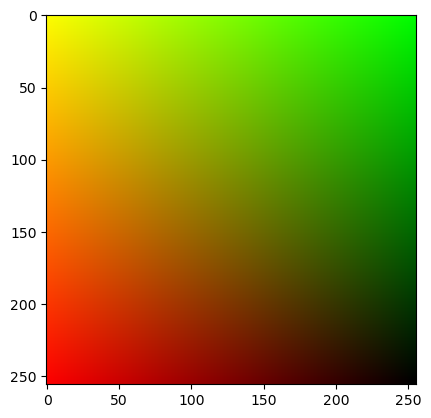

In [8]:
image_grid = vis_grid(xy_grid, image_size)
plt.imshow(np.uint8(image_grid * 255));

### Get Rays from Pixels

In [9]:
def get_rays_from_pixels_nb(xy_grid, image_size=None, camera=None):
    # Map pixels to points on the image plane at Z=1
    xyz_grid = torch.cat((xy_grid, torch.ones(xy_grid.shape[0]).unsqueeze(-1)), dim=-1)

    # Use camera.unproject to get world space points on the image plane from NDC space points
    world_coords = camera.unproject_points(xyz_grid)

    # Get ray origins from camera center
    ray_origins = camera.get_camera_center().repeat(xyz_grid.shape[0], 1)

    # Get normalized ray directions
    ray_directions = F.normalize(world_coords - ray_origins)
    return RayBundle(
            origins=ray_origins,
            directions=ray_directions,
            lengths=None,
            xys=None)

###### Visualize Rays

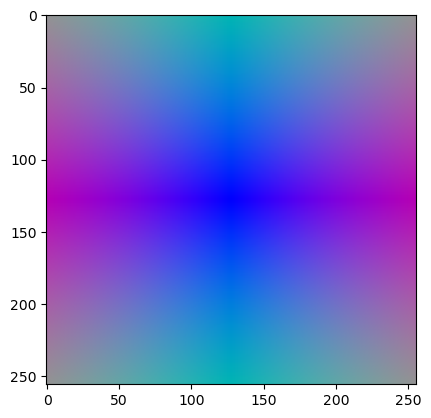

In [10]:
ray_bundle = get_rays_from_pixels_nb(xy_grid, image_size, camera.to('cpu')) # TODO (1.3): implement in ray_utils.py

ray_grid = vis_rays(ray_bundle, image_size)
plt.imshow(np.uint8(ray_grid * 255));

## Point sampling

In [11]:
# Sampler which implements stratified (uniform) point sampling along rays

class StratifiedRaysamplerNB(torch.nn.Module):
    def __init__(
        self,
        n_pts_per_ray=64, min_depth=0.0, max_depth=5.0
    ):
        super().__init__()

        self.n_pts_per_ray = n_pts_per_ray
        self.min_depth = min_depth
        self.max_depth = max_depth

    def forward(
        self,
        ray_bundle,
    ):
        # Compute z values for self.n_pts_per_ray points uniformly sampled between [near, far]
        z_values = torch.linspace(start=self.min_depth, end=self.max_depth, 
                                  steps=self.n_pts_per_ray)
        z_values = z_values[None, :, None].repeat(len(ray_bundle.origins), 1, 3)

        directions = ray_bundle.directions[:, None, :].repeat(1, self.n_pts_per_ray, 1)

        # Sample points from z values
        sample_points = ray_bundle.origins[:, None, :] + directions * z_values

        return ray_bundle._replace(lengths = z_values * torch.ones_like(sample_points[..., :1]),
                            xys = sample_points)
        


sampler_dict = {
    'stratified': StratifiedRaysamplerNB
}

In [12]:
sampler = sampler_dict['stratified'](n_pts_per_ray=64, min_depth=0.0, max_depth=5.0)

In [13]:
ray_bundle = sampler(ray_bundle)       

##### Visualize sample points as point cloud

In [14]:
xys = ray_bundle.xys
xys.shape

torch.Size([65536, 64, 3])

In [15]:
xys = xys.reshape(shape = (-1, 3))

print(xys.shape)

torch.Size([4194304, 3])


In [16]:
rend = render_points('pt_cloud.png', xys.unsqueeze(0).cuda(), device='cuda')

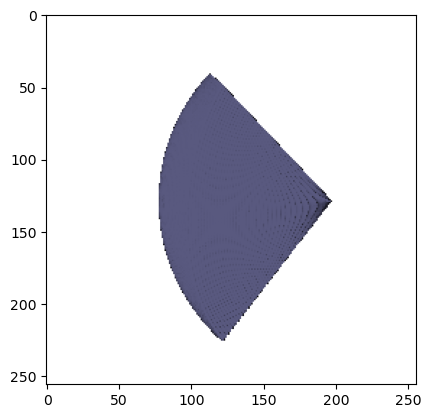

In [17]:
plt.imshow(rend);

### Volume rendering

In [18]:
import hydra

from hydra import initialize, initialize_config_module, initialize_config_dir, compose

In [19]:
with initialize(version_base=None, config_path="./configs"):
    cfg = compose('box.yaml')

In [20]:
from main import render

render(cfg)

C:\OMSCS\dl\project\assignment3\main.py:373: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='./configs', config_name='sphere')


Rendering image 0
sample_points.shape torch.Size([4194304, 3])
Rendering image 1
Rendering image 2
Rendering image 3
Rendering image 4
Rendering image 5
Rendering image 6
Rendering image 7
Rendering image 8
Rendering image 9
Rendering image 10
Rendering image 11
Rendering image 12
Rendering image 13
Rendering image 14
Rendering image 15
Rendering image 16
Rendering image 17
Rendering image 18
Rendering image 19


In [23]:
from typing import List, Optional, Tuple
from pytorch3d.renderer.cameras import CamerasBase


# Volume renderer which integrates color and density along rays
# according to the equations defined in [Mildenhall et al. 2020]
class VolumeRenderer(torch.nn.Module):
    def __init__(
        self,
        cfg
    ):
        super().__init__()

        self._chunk_size = cfg.chunk_size
        self._white_background = cfg.white_background if 'white_background' in cfg else False

    def _compute_weights(
        self,
        deltas,
        rays_density: torch.Tensor,
        eps: float = 1e-10
    ):
        # Compute weight used for rendering from transmittance and density
#         transmittances = torch.exp(-torch.cumsum(rays_density * deltas, dim=1))
#         weights = (1. - transmittances) * torch.flip(transmittances, dims=[1]) * rays_density
#         weights = weights.permute(0, 2, 1).contiguous()
        n_rays, n_points, _ = deltas.shape

        transmittance = torch.ones(n_rays, 1, device=deltas.device)
        weight = transmittance * (1. - torch.exp(-rays_density[:, 0] * deltas[:, 0]))

        transmittances = [transmittance]
        weights = [weight]

        for i in range(1, n_points):
            transmittance = transmittances[i-1] * torch.exp(-rays_density[:, i-1] * deltas[:, i-1])
            transmittances.append(transmittance)
            weight = transmittance * (1. - torch.exp(-rays_density[:, i] * deltas[:, i]))
            weights.append(weight)

        # TODO (1.5): Compute weight used for rendering from transmittance and density
        weights = torch.stack(weights).to(deltas.device)
        weights = weights.permute(1, 0, 2)
        return weights
    
    
    def _aggregate(
        self,
        weights: torch.Tensor,
        rays_feature: torch.Tensor
    ):
        # Aggregate (weighted sum of) features using weights
        N, P, _ = weights.shape
        rays_feature = rays_feature.reshape(N, P, -1)
        feature = torch.matmul(weights.transpose(1, 2), rays_feature).squeeze(1)
        return feature

    def forward(
        self,
        sampler,
        implicit_fn,
        ray_bundle,
    ):
        B = ray_bundle.shape[0]

        # Process the chunks of rays.
        chunk_outputs = []

        for chunk_start in range(0, B, self._chunk_size):
            cur_ray_bundle = ray_bundle[chunk_start:chunk_start+self._chunk_size]

            # Sample points along the ray
            cur_ray_bundle = sampler(cur_ray_bundle)
            n_pts = cur_ray_bundle.sample_shape[1]

            # Call implicit function with sample points
            implicit_output = implicit_fn(cur_ray_bundle)
            density = implicit_output['density']
            feature = implicit_output['feature']

            # Compute length of each ray segment
            depth_values = cur_ray_bundle.sample_lengths[..., 0]
            deltas = torch.cat(
                (
                    depth_values[..., 1:] - depth_values[..., :-1],
                    1e10 * torch.ones_like(depth_values[..., :1]),
                ),
                dim=-1,
            )[..., None]

            # Compute aggregation weights
            weights = self._compute_weights(
                deltas.view(-1, n_pts, 1),
                density.view(-1, n_pts, 1)
            ) 

            # Render (color) features using weights
            feature = self._aggregate(weights, feature)

            # Render depth map
            depth = self._aggregate(weights, depth_values.unsqueeze(-1))


            # Return
            cur_out = {
                'feature': feature,
                'depth': depth,
            }

            chunk_outputs.append(cur_out)

        # Concatenate chunk outputs
        out = {
            k: torch.cat(
              [chunk_out[k] for chunk_out in chunk_outputs],
              dim=0
            ) for k in chunk_outputs[0].keys()
        }

        return out

In [24]:
from implicit import volume_dict
from sampler import sampler_dict
from renderer import renderer_dict


class Model(torch.nn.Module):
    def __init__(
        self,
        cfg
    ):
        super().__init__()

        # Get implicit function from config
        self.implicit_fn = volume_dict[cfg.implicit_function.type](
            cfg.implicit_function
        )

        # Point sampling (raymarching) scheme
        self.sampler = sampler_dict[cfg.sampler.type](
            cfg.sampler
        )

        # Initialize volume renderer
        self.renderer = renderer_dict[cfg.renderer.type](
            cfg.renderer
        )
    
    def forward(
        self,
        ray_bundle
    ):
        # Call renderer with
        #  a) Implicit volume
        #  b) Sampling routine

        return self.renderer(
            self.sampler,
            self.implicit_fn,
            ray_bundle
        )

In [25]:
# from main import Model

model = Model(cfg)
model = model.cuda()
model.eval()

cameras = create_surround_cameras(3.0, n_poses=20)

In [26]:
image_size = cfg.data.image_size

In [27]:
from ray_utils import (
    sample_images_at_xy,
    get_pixels_from_image,
    get_random_pixels_from_image,
    get_rays_from_pixels
)

In [28]:
file_prefix=''
save=False

In [29]:
all_images = []
device = list(model.parameters())[0].device

for cam_idx, camera in enumerate(cameras):
    print(f'Rendering image {cam_idx}')

    torch.cuda.empty_cache()
    camera = camera.to(device)
    xy_grid = get_pixels_from_image(image_size, camera).cuda() # TODO (1.3): implement in ray_utils.py
    ray_bundle = get_rays_from_pixels(xy_grid, image_size, camera) # TODO (1.3): implement in ray_utils.py

    ray_bundle = model.sampler(ray_bundle)

    out = model(ray_bundle)

    # Return rendered features (colors)
    image = np.array(
        out['feature'].view(
            image_size[1], image_size[0], 3
        ).detach().cpu()
    )
    all_images.append(image)

    if cam_idx == 2 and file_prefix == '':
        depth_map = np.array(out['depth'].view(image_size[1], image_size[0]).detach().cpu())
        plt.imsave('out/1_5/depth_map_nb.png', depth_map)

Rendering image 0
Rendering image 1
Rendering image 2
Rendering image 3
Rendering image 4
Rendering image 5
Rendering image 6
Rendering image 7
Rendering image 8
Rendering image 9
Rendering image 10
Rendering image 11
Rendering image 12
Rendering image 13
Rendering image 14
Rendering image 15
Rendering image 16
Rendering image 17
Rendering image 18
Rendering image 19


In [30]:
import imageio
imageio.mimsave('images/part_1_nb5.gif', [np.uint8(im * 255) for im in all_images])

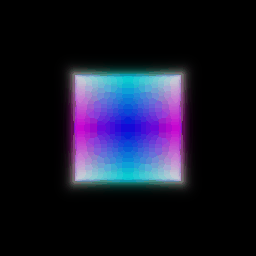

## 2. Optimizing a basic implicit volume


In [34]:
with initialize(version_base=None, config_path="./configs"):
    cfg = compose('train_box.yaml')

### Random ray sampling

In [47]:
# Random subsampling of pixels from an image
def get_random_pixels_from_image(n_pixels, image_size, camera):
    xy_grid = get_pixels_from_image(image_size, camera)
    
    # TODO (2.1): Random subsampling of pixel coordinates
    random_indices = torch.randperm(xy_grid.shape[0])
    xy_grid_sub = xy_grid[random_indices, :].cuda()

    # Return
    return xy_grid_sub.reshape(-1, 2)[:n_pixels]

### Loss and training

Box center: (0.25, 0.25, 0.00)

Box side lengths: (2.01, 1.50, 1.50)

### Visualization

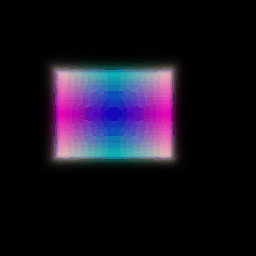

## 3. Optimizing a Neural Radiance Field (NeRF) (30 points)

In [ ]:
F.MSE

### Rough

In [53]:
import torch

# create a tensor
x = torch.tensor([1, 2, 3, 4, 5, 6])

In [54]:
x.shape

torch.Size([6])

In [57]:
x.unsqueeze(1)

tensor([[1],
        [2],
        [3],
        [4],
        [5],
        [6]])

In [58]:
x

tensor([1, 2, 3, 4, 5, 6])

In [61]:
x[...,None]

tensor([[1],
        [2],
        [3],
        [4],
        [5],
        [6]])

In [66]:
ray_origins

tensor([[ 0.9271,  0.0000, -2.8532],
        [ 0.9271,  0.0000, -2.8532],
        [ 0.9271,  0.0000, -2.8532],
        ...,
        [ 0.9271,  0.0000, -2.8532],
        [ 0.9271,  0.0000, -2.8532],
        [ 0.9271,  0.0000, -2.8532]], device='cuda:0')

In [65]:
# Map pixels to points on the image plane at Z=1
xyz_grid = torch.cat((xy_grid.cuda(), torch.ones(xy_grid.shape[0], device='cuda').unsqueeze(-1)), dim=-1)

# Use camera.unproject to get world space points on the image plane from NDC space points
world_coords = camera.unproject_points(xyz_grid)

# Get ray origins from camera center
ray_origins = camera.get_camera_center().repeat(xyz_grid.shape[0], 1)

In [68]:
ray_origins[...,None].shape

torch.Size([65536, 3, 1])

In [69]:
ray_origins.shape

torch.Size([65536, 3])

In [71]:
    torch.zeros_like(ray_origins).shape

torch.Size([65536, 3])

In [72]:
torch.zeros_like(ray_origins).unsqueeze(1).shape

torch.Size([65536, 1, 3])

In [76]:
torch.zeros_like(ray_origins)[...,None].permute(0,2,1).shape

torch.Size([65536, 1, 3])